In [1]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
%matplotlib inline

# Stages of Growth

Do we see distinct changes on each tile in terms of _stages_ (Transferring from creating objects to editing objects)

In [2]:
study_tiles = [
    {"name" : "Port Au Prince, Haiti", "quad" : "032211203001"},   
    {"name" : "Trisuli Bazar, Nepal",  "quad" : "123131221200"},
    {"name" : "Tacloban",              "quad" : "132312223332"},
    {"name" : "Kenema, Sierra Leone",  "quad" : "033330200220"},
    {"name" : "Monrovia, Liberia",     "quad" : "033330222101"},
    {"name" : "Kathmandu, Nepal",      "quad" : "123131221232"},
    {"name" : "Heidelberg, Germany",   "quad" : "120203320232"},
    {"name" : "London",                "quad" : "031313131103"},
    {"name" : "Berlin",                  "quad" : "120210233222"},
    {"name" : "Manhattan, NY",           "quad" : "032010110132"},
    {"name" : "Denver, CO",              "quad" : "023101030121"},
]

In [5]:
NROWS = 4
NCOLS = 2
FIGSIZE = (15,25)
WSPACE=0.3
HSPACE=0.4
sns.set(font_scale=1.25)

In [6]:
#Create the engine for Pandas to query SQL with
engine = create_engine('postgresql://anderstj@127.0.0.1:5432/osm-quality-full')

In [7]:
def get_full_quadkey_df(tile):
    df = pd.read_sql_query("SELECT * FROM tiles_per_year WHERE quadkey = '%s' order by year"%(tile['quad']),con=engine)
    df['name'] = tile['name']
    return df
x = get_full_quadkey_df(study_tiles[-1])

In [8]:
x.tail(3)

,id,quadkey,year,new_road_km,new_buildings,new_amenities,new_objects,edited_road_km,edited_buildings,edited_amenities,edited_objects,users_new_obj,users_edited_obj,name
7,30776215,023101030121,2014,207.495,1503,489,8537,771.534,3039,632,7852,59,85,"Denver, CO"
8,40214785,023101030121,2015,376.822,3570,1004,28490,1261.210,7928,776,19601,56,88,"Denver, CO"
9,48383350,023101030121,2016,127.365,1317,168,8319,564.001,1770,234,6526,53,73,"Denver, CO"


In [9]:
"""
    Helper functions for annual and cumulative sums
"""
def get_annual_percentage_of_new_edits(row):
#     print(row)
    if row['edited_objects'] > 0 or row['new_objects']>0:
        return row['new_objects']/(row['edited_objects']+row['new_objects'])
    else:
        return 0
    
def get_annual_percentage_of_edited_objects(row):
#     print(row)
    if row['edited_objects'] > 0 or row['new_objects']>0:
        return row['edited_objects']/(row['edited_objects']+row['new_objects'])
    else:
        return 0

In [10]:
for tile in study_tiles:
    tile['df'] = get_full_quadkey_df(tile)

## Edited Objects Overtime

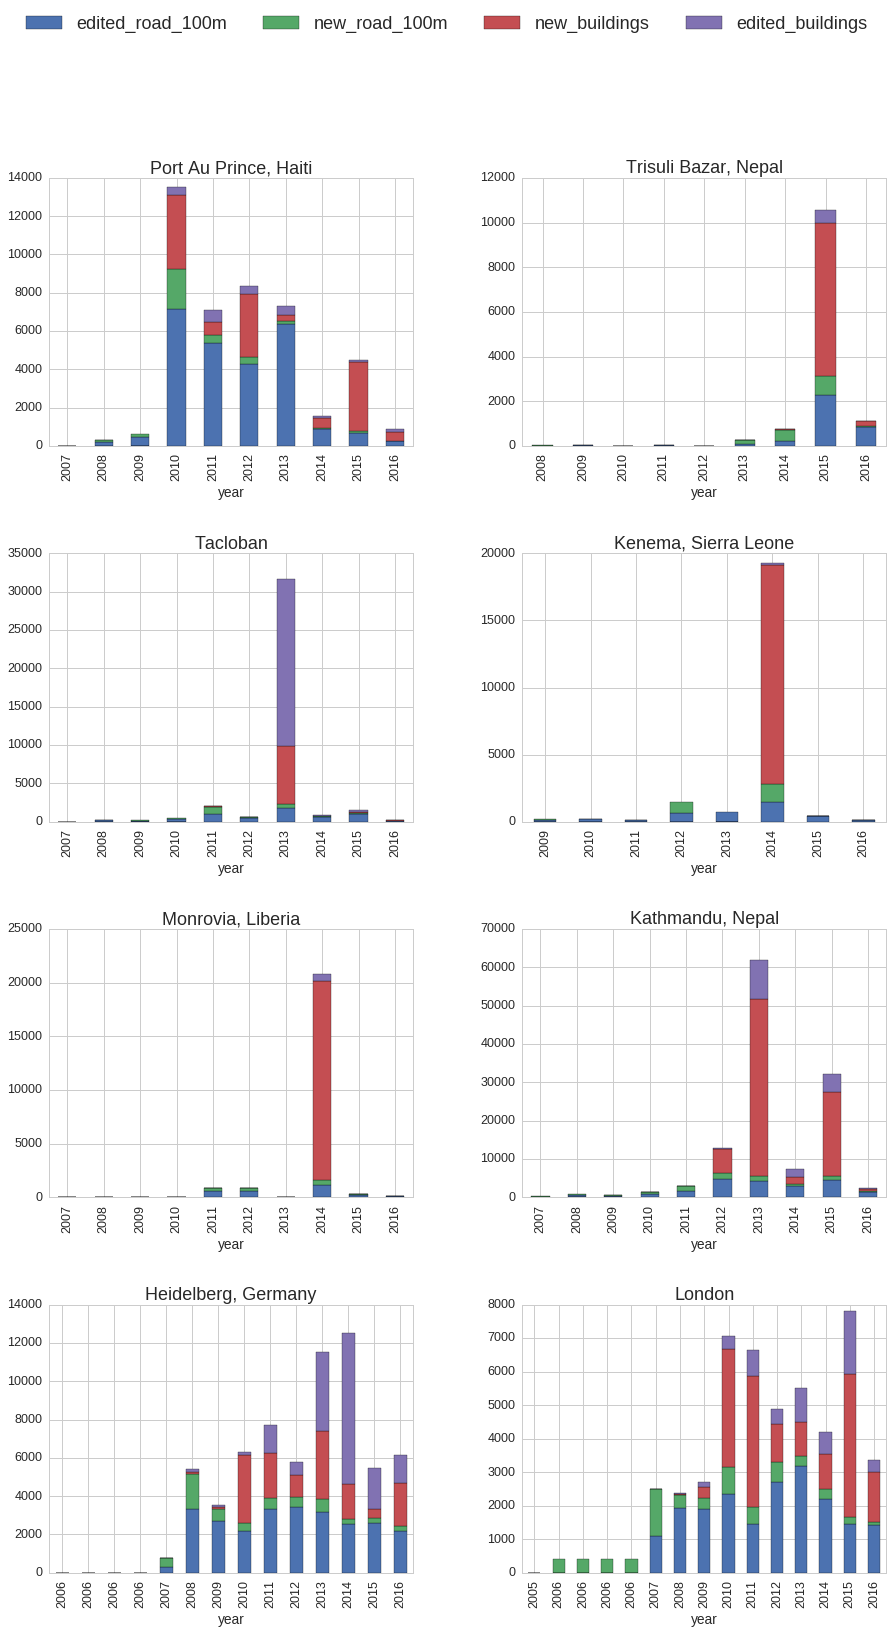

In [11]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    df = tile['df']
    
    roads = df[['new_road_km','edited_road_km','year']].copy()
#     roads.plot(ax=ax, kind='bar', stacked=True)

    roads['new_road_100m'] = roads.new_road_km*10
    roads['edited_road_100m'] = roads.edited_road_km*10
  
    
    #BUILDINGS

    buildings = df[['new_buildings','edited_buildings','year']].copy()
#     buildings.plot(ax=ax, kind='bar', stacked=True, x='year')
    
#     buildings['percent_new']    = buildings.new_buildings / (buildings.new_buildings + buildings.edited_buildings)
#     buildings['percent_edited'] = buildings.edited_buildings / (buildings.new_buildings + buildings.edited_buildings)
#     buildings[['percent_new','percent_edited','year']].plot(ax=ax, kind='bar', stacked=True, x='year')
    
    
    #OKAY, NOW FOR SOMETHING REALLY CRAZY... CAN WE DO IT ALL STACKED?
    
    total_roads_and_buildings = roads[['edited_road_100m','new_road_100m','year']].merge(buildings, on='year')

    total_roads_and_buildings.plot(ax=ax,kind='bar',stacked=True,x='year')
    
    #     ax.set_xticklabels(df.year)
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)

## Analysis

We see very different stages of growth between tiles where disaster mapping has clearly occured and tiles where there are active communities.

More importantly, each of the HOT activations called for different objects to be mapped: _buildings_ or _roads_, as is evidenced by the difference between Haiti (2010) and Tacloban or Nepal. Note also, that buildings were edited more than added in Tacloban - there was a lot of damage assessment work being done with these data.


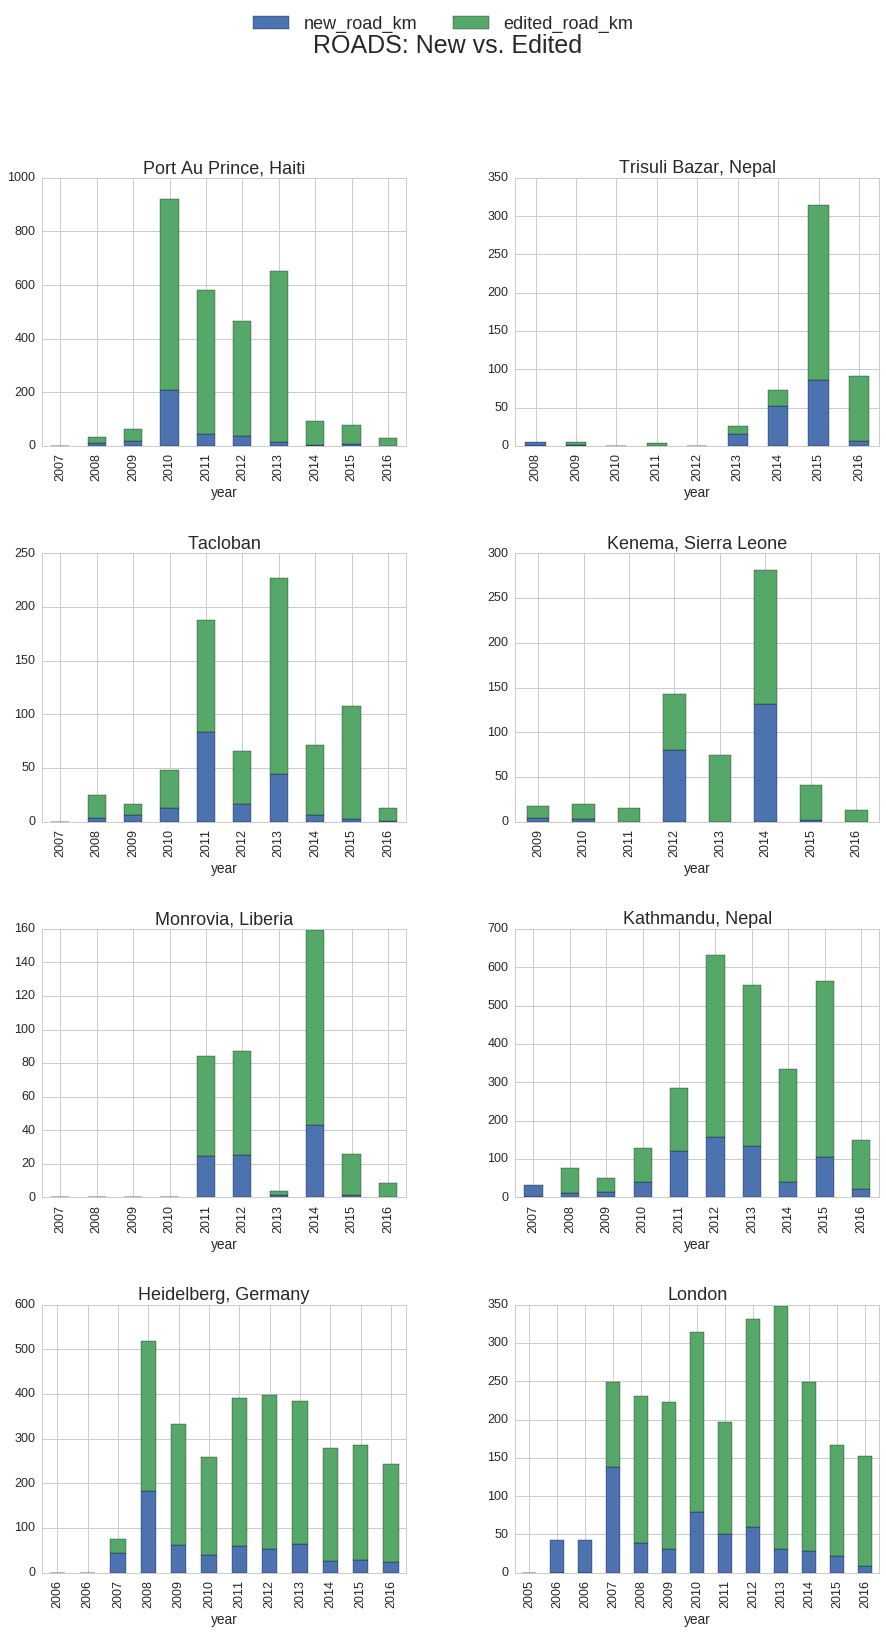

In [16]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
    roads.plot(ax=ax, kind='bar', stacked=True, x='year')
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("ROADS: New vs. Edited",fontsize=25)

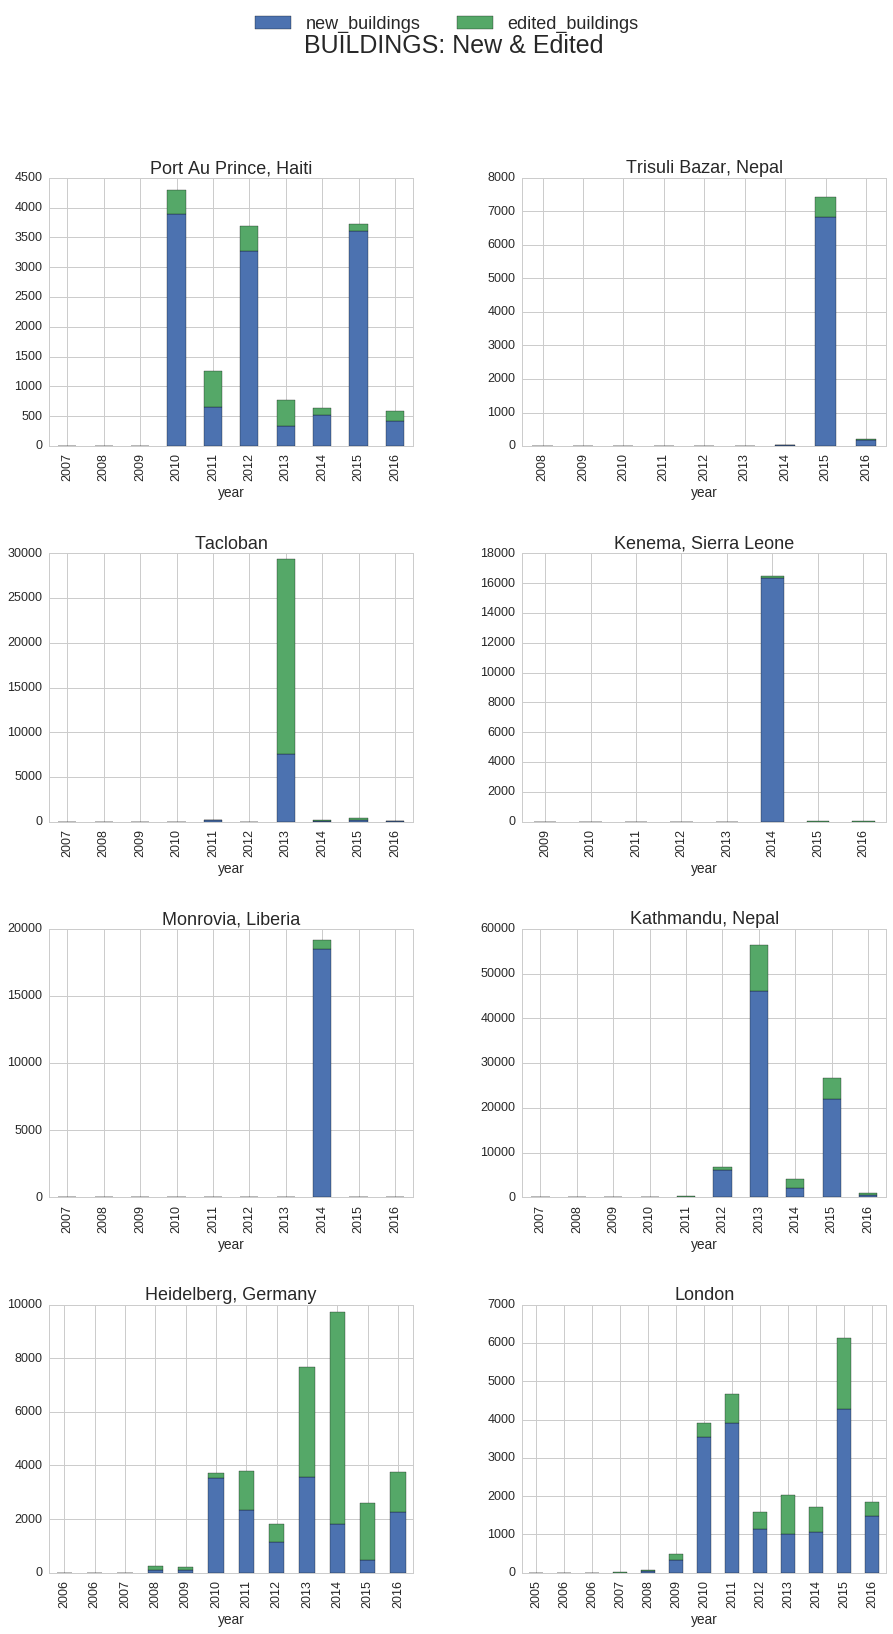

In [17]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    #BUILDINGS
    buildings =  tile['df'][['new_buildings','edited_buildings','year']].copy()
    buildings.plot(ax=ax, kind='bar', stacked=True, x='year')
            
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("BUILDINGS: New & Edited",fontsize=25)

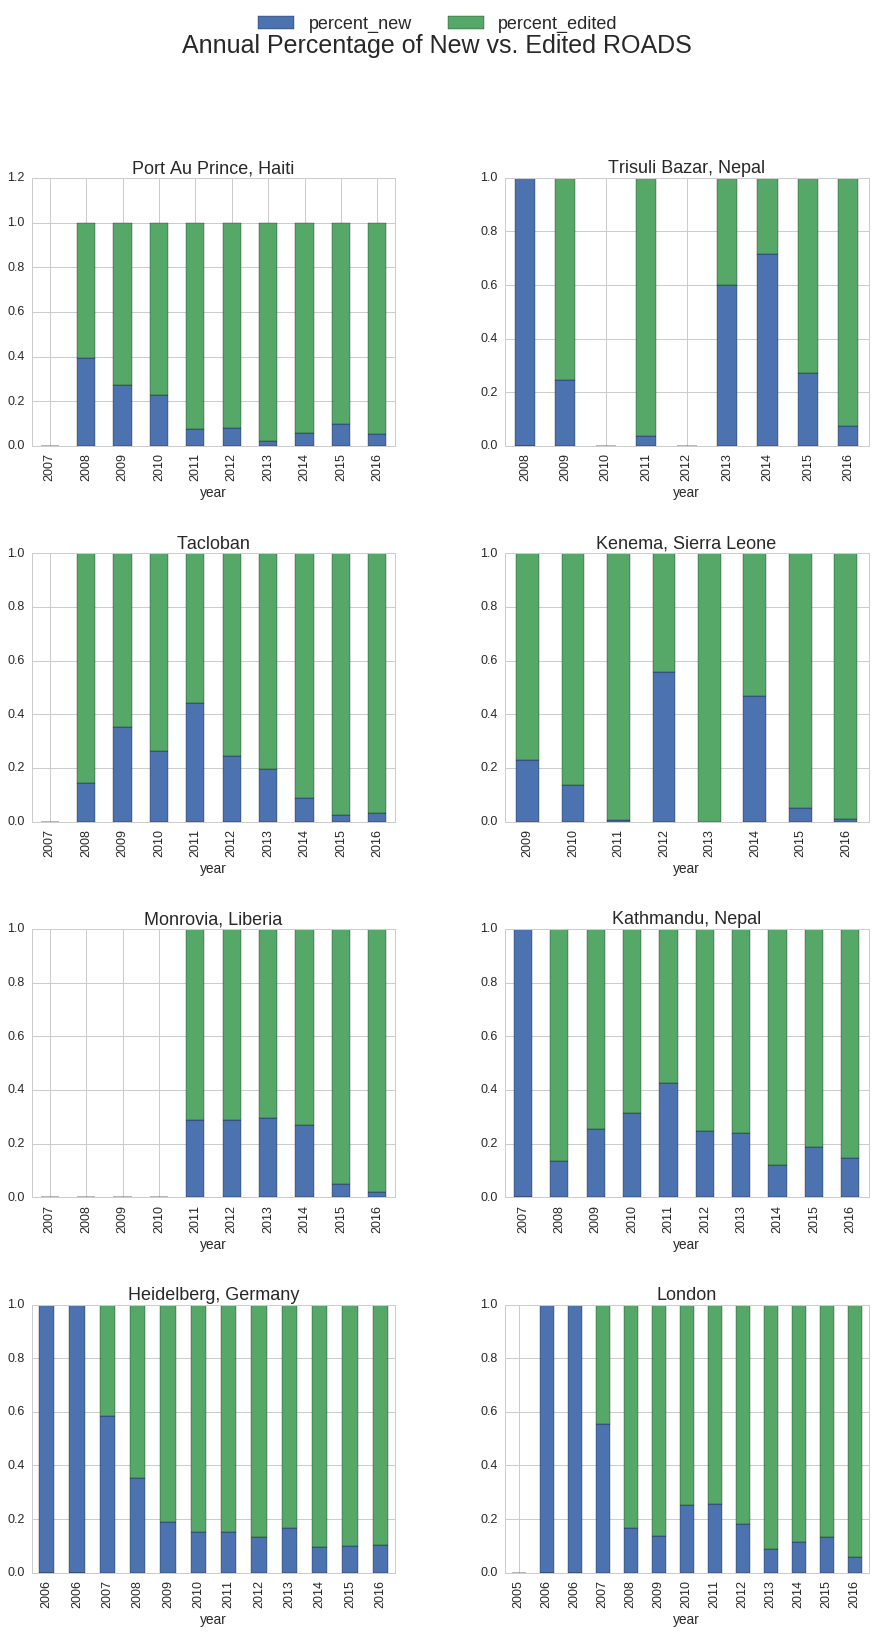

In [20]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    roads = tile['df'][['new_road_km','edited_road_km','year']].copy()
  
    roads['percent_new'] = roads.new_road_km / (roads.new_road_km + roads.edited_road_km)
    roads['percent_edited'] = roads.edited_road_km / (roads.new_road_km + roads.edited_road_km)
    roads[['percent_new','percent_edited','year']].plot(ax=ax, kind='bar', stacked=True, x='year')

    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("Annual Percentage of New vs. Edited ROADS", fontsize=25)

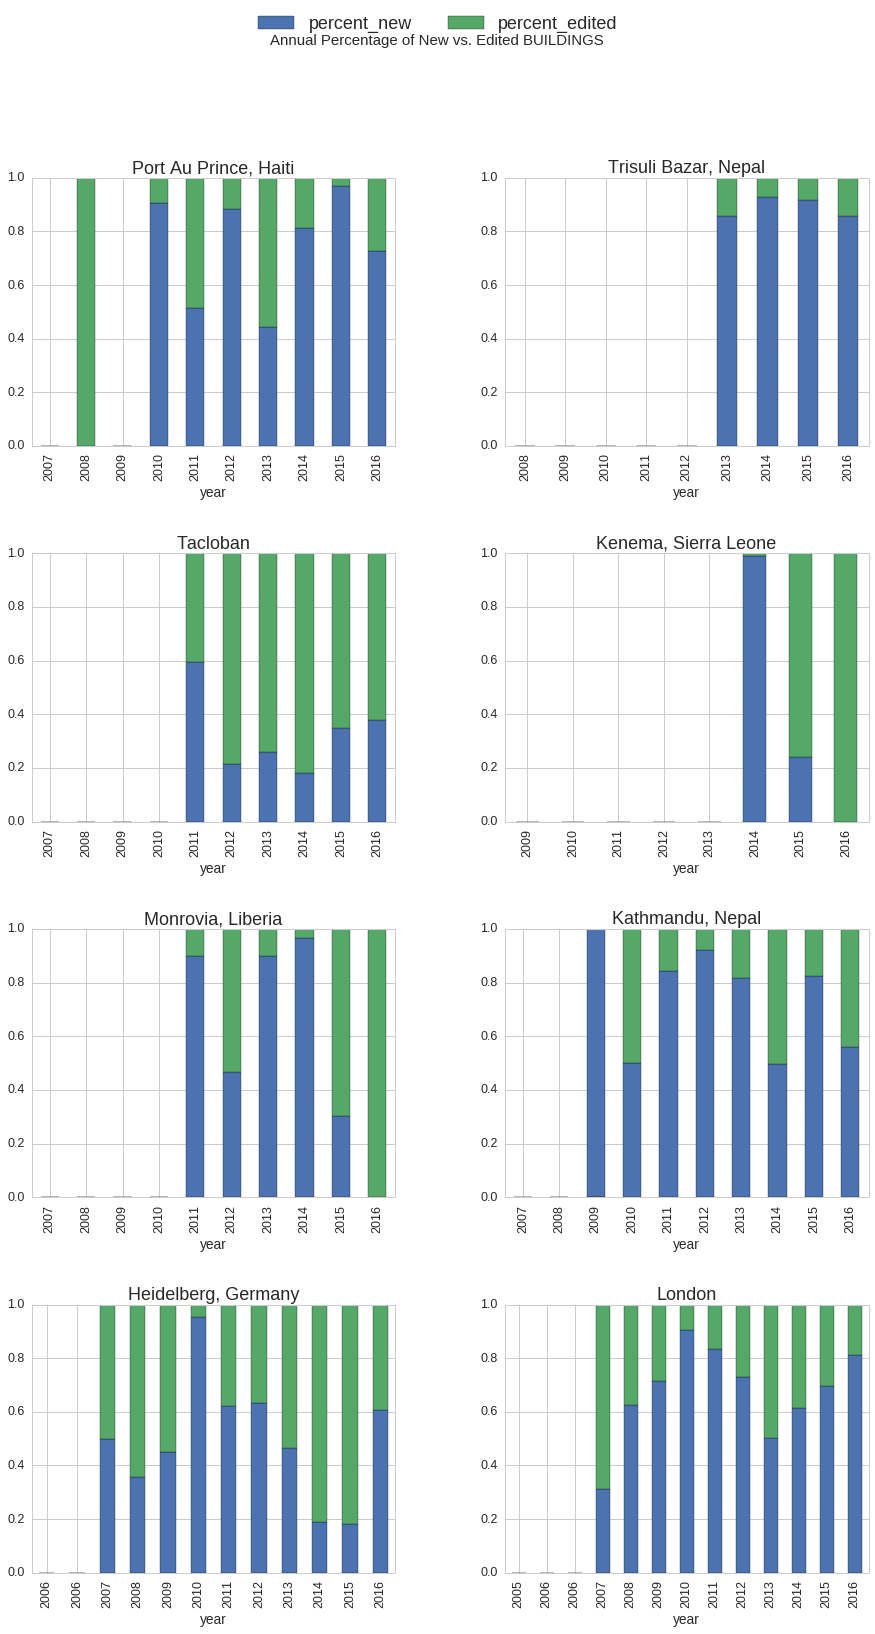

In [21]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=FIGSIZE, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
axes = list(axs.ravel())

for (idx, tile), ax in zip(enumerate(study_tiles), axes):    
    
    ax.set_title(tile['name'], fontsize=18)
    
    #BUILDINGS
    buildings = tile['df'][['new_buildings','edited_buildings','year']].copy()
    buildings['percent_new']    = buildings.new_buildings / (buildings.new_buildings + buildings.edited_buildings)
    buildings['percent_edited'] = buildings.edited_buildings / (buildings.new_buildings + buildings.edited_buildings)
    buildings[['percent_new','percent_edited','year']].plot(ax=ax, kind='bar', stacked=True, x='year')
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend(handles,labels,
              loc = ('upper center'), ncol=4, fontsize=18)
plt.suptitle("Annual Percentage of New vs. Edited BUILDINGS")

## Percentage of Total Objects (Each Year)

Port Au Prince, Haiti
Trisuli Bazar, Nepal
Tacloban
Kenema, Sierra Leone
Monrovia, Liberia
Kathmandu, Nepal
Heidelberg, Germany
London


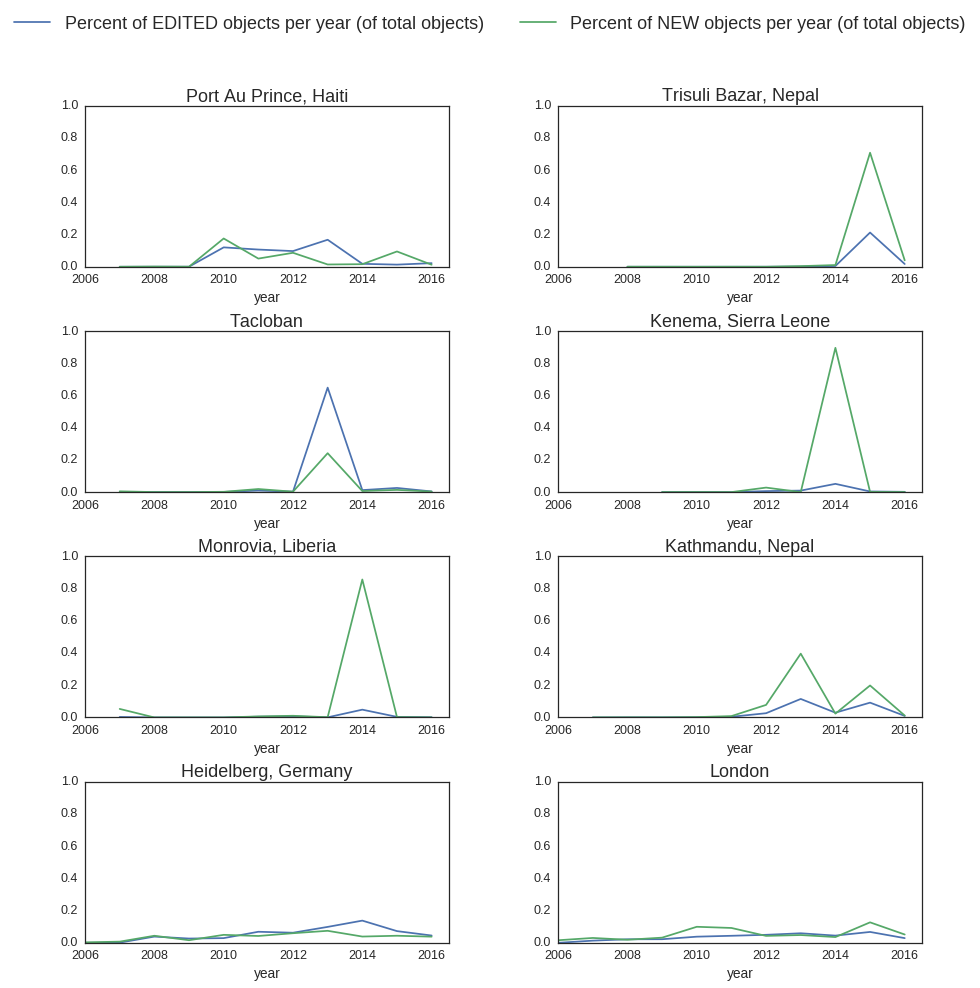

In [327]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
        
    print(tile['name'])
    
    df = tile['df'].copy()
    
    df['cumulative_new_objects'] = pd.Series.cumsum(df.new_objects)
    df['cumulative_edited_objects'] = pd.Series.cumsum(df.edited_objects)
    
    df['percentage_of_years_edits_that_are_new'] = df.apply(lambda row: get_annual_percentage_of_new_edits(row), axis=1)
    df['percentage_of_years_edits_that_are_edited'] = df.apply(lambda row: get_annual_percentage_of_edited_objects(row), axis=1)
    
    df['total_annual_objects'] = df.new_objects + df.edited_objects
    
    df['edited_obj_percent'] = df.edited_objects / df['total_annual_objects'].sum()
    df['new_obj_percent']    = df.new_objects    / df['total_annual_objects'].sum()
    
    df[['edited_obj_percent','new_obj_percent','year']].plot(kind='bar',x='year')
    
#     df.plot(ax=ax, x='year', y='edited_obj_percent', legend=False)
#     df.plot(ax=ax, x='year', y='new_obj_percent', legend=False)
    
    ax.set_xlim(2006,2016.5)
    ax.set_ylim(0,1)
    ax.set_title(tile['name'],fontsize=18)
    
    line1 = ax.get_lines()[0]
    line2 = ax.get_lines()[1]
plt.figlegend( [line1, line2],
              ["Percent of EDITED objects per year (of total objects)", 
               "Percent of NEW objects per year (of total objects)"], 
                loc = ('upper center'), ncol=3, fontsize=18)

In [328]:
df.head()

,id,quadkey,year,new_road_km,new_buildings,new_amenities,new_objects,edited_road_km,edited_buildings,edited_amenities,edited_objects,users_new_obj,users_edited_obj,percentage_of_years_edits_that_are_new,percentage_of_years_edits_that_are_edited,cumulative_new_objects,cumulative_edited_objects,total_annual_objects,edited_obj_percent,new_obj_percent
0,315,031313131103,2005,0.0000,0,0,55,0.000,0,0,0,3,0,1.000000,0.000000,55,0,55,0.000000,0.000828
1,8716,031313131103,2006,42.2041,0,1,1057,0.000,0,0,0,15,0,1.000000,0.000000,1112,0,1057,0.000000,0.015906
2,31483,031313131103,2006,42.2041,0,1,1057,0.000,0,0,0,15,0,1.000000,0.000000,2169,0,1057,0.000000,0.015906
3,253732,031313131103,2007,138.3260,5,60,2002,110.490,11,17,889,36,29,0.692494,0.307506,4171,889,2891,0.013378,0.030127
4,913527,031313131103,2008,39.0327,40,198,1258,192.228,24,94,1452,43,66,0.464207,0.535793,5429,2341,2710,0.021850,0.018931


# Roads (New vs. Edited)

Port Au Prince, Haiti
Trisuli Bazar, Nepal
Tacloban
Kenema, Sierra Leone
Monrovia, Liberia
Kathmandu, Nepal
Heidelberg, Germany
London


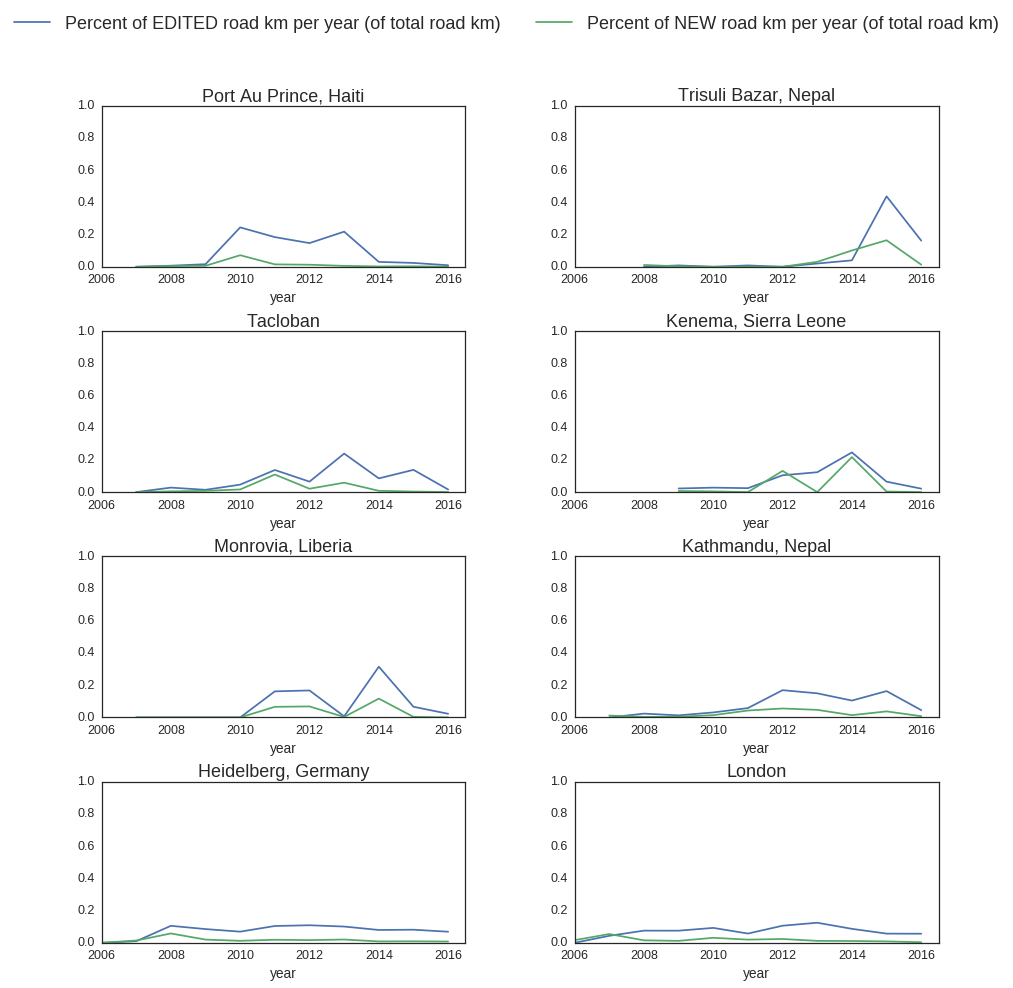

In [329]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
CURSOR = reset_cursor()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
        
    print(tile['name'])
    
    df = tile['df']
    
    df['total_annual_roads']   = df.new_road_km + df.edited_road_km
    
    df['edited_road_km_percent'] = df.edited_road_km / df['total_annual_roads'].sum()
    df['new_road_km_percent']    = df.new_road_km    / df['total_annual_roads'].sum()
    
    df.plot(ax=ax, x='year', y='edited_road_km_percent', legend=False)
    df.plot(ax=ax, x='year', y='new_road_km_percent', legend=False)
    
    ax.set_xlim(2006,2016.5)
    ax.set_ylim(0,1)
    ax.set_title(tile['name'],fontsize=18)
    
    line1 = ax.get_lines()[0]
    line2 = ax.get_lines()[1]
plt.figlegend( [line1, line2],
              ["Percent of EDITED road km per year (of total road km)", 
               "Percent of NEW road km per year (of total road km)"], 
                loc = ('upper center'), ncol=3, fontsize=18)

# Buildings (New vs. Edited)

In [330]:
df.head()

,id,quadkey,year,new_road_km,new_buildings,new_amenities,new_objects,edited_road_km,edited_buildings,edited_amenities,edited_objects,users_new_obj,users_edited_obj,percentage_of_years_edits_that_are_new,percentage_of_years_edits_that_are_edited,cumulative_new_objects,cumulative_edited_objects,total_annual_objects,edited_obj_percent,new_obj_percent,total_annual_roads,edited_road_km_percent,new_road_km_percent
0,315,031313131103,2005,0.0000,0,0,55,0.000,0,0,0,3,0,1.000000,0.000000,55,0,55,0.000000,0.000828,0.0000,0.000000,0.000000
1,8716,031313131103,2006,42.2041,0,1,1057,0.000,0,0,0,15,0,1.000000,0.000000,1112,0,1057,0.000000,0.015906,42.2041,0.000000,0.016586
2,31483,031313131103,2006,42.2041,0,1,1057,0.000,0,0,0,15,0,1.000000,0.000000,2169,0,1057,0.000000,0.015906,42.2041,0.000000,0.016586
3,253732,031313131103,2007,138.3260,5,60,2002,110.490,11,17,889,36,29,0.692494,0.307506,4171,889,2891,0.013378,0.030127,248.8160,0.043423,0.054363
4,913527,031313131103,2008,39.0327,40,198,1258,192.228,24,94,1452,43,66,0.464207,0.535793,5429,2341,2710,0.021850,0.018931,231.2607,0.075546,0.015340


Port Au Prince, Haiti
Trisuli Bazar, Nepal
Tacloban
Kenema, Sierra Leone
Monrovia, Liberia
Kathmandu, Nepal
Heidelberg, Germany
London


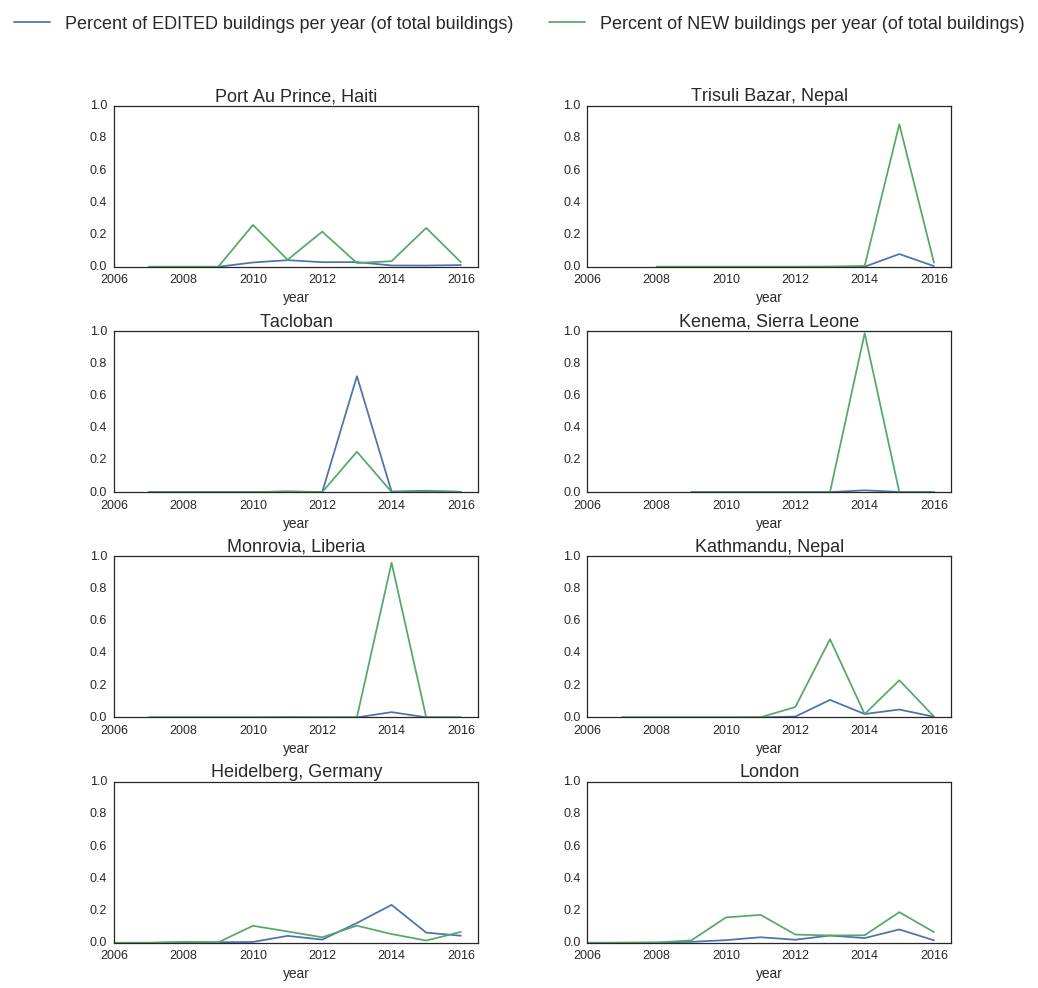

In [331]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
CURSOR = reset_cursor()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
    

for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
        
    print(tile['name'])
    
    df = tile['df']
    
    df['total_annual_buildings']   = df.new_buildings + df.edited_buildings
    
    df['edited_building_percent']  = df.edited_buildings    / df['total_annual_buildings'].sum()
    df['new_building_percent']     = df.new_buildings       / df['total_annual_buildings'].sum()
    
    df.plot(ax=ax, x='year', y='edited_building_percent', legend=False)
    df.plot(ax=ax, x='year', y='new_building_percent', legend=False)

    ax.set_xlim(2006,2016.5)
    ax.set_ylim(0,1)
    ax.set_title(tile['name'],fontsize=18)
    
    line1 = ax.get_lines()[0]
    line2 = ax.get_lines()[1]
plt.figlegend( [line1, line2],
              ["Percent of EDITED buildings per year (of total buildings)", 
               "Percent of NEW buildings per year (of total buildings)"], 
                loc = ('upper center'), ncol=3, fontsize=18)

## Explore the number of users that are making these edits?

In [332]:
pd.set_option('display.max_columns', None)
df.head()

,id,quadkey,year,new_road_km,new_buildings,new_amenities,new_objects,edited_road_km,edited_buildings,edited_amenities,edited_objects,users_new_obj,users_edited_obj,percentage_of_years_edits_that_are_new,percentage_of_years_edits_that_are_edited,cumulative_new_objects,cumulative_edited_objects,total_annual_objects,edited_obj_percent,new_obj_percent,total_annual_roads,edited_road_km_percent,new_road_km_percent,total_annual_buildings,edited_building_percent,new_building_percent
0,315,031313131103,2005,0.0000,0,0,55,0.000,0,0,0,3,0,1.000000,0.000000,55,0,55,0.000000,0.000828,0.0000,0.000000,0.000000,0,0.00000,0.000000
1,8716,031313131103,2006,42.2041,0,1,1057,0.000,0,0,0,15,0,1.000000,0.000000,1112,0,1057,0.000000,0.015906,42.2041,0.000000,0.016586,0,0.00000,0.000000
2,31483,031313131103,2006,42.2041,0,1,1057,0.000,0,0,0,15,0,1.000000,0.000000,2169,0,1057,0.000000,0.015906,42.2041,0.000000,0.016586,0,0.00000,0.000000
3,253732,031313131103,2007,138.3260,5,60,2002,110.490,11,17,889,36,29,0.692494,0.307506,4171,889,2891,0.013378,0.030127,248.8160,0.043423,0.054363,16,0.00049,0.000223
4,913527,031313131103,2008,39.0327,40,198,1258,192.228,24,94,1452,43,66,0.464207,0.535793,5429,2341,2710,0.021850,0.018931,231.2607,0.075546,0.015340,64,0.00107,0.001783


Port Au Prince, Haiti
Trisuli Bazar, Nepal
Tacloban
Kenema, Sierra Leone
Monrovia, Liberia
Kathmandu, Nepal
Heidelberg, Germany
London


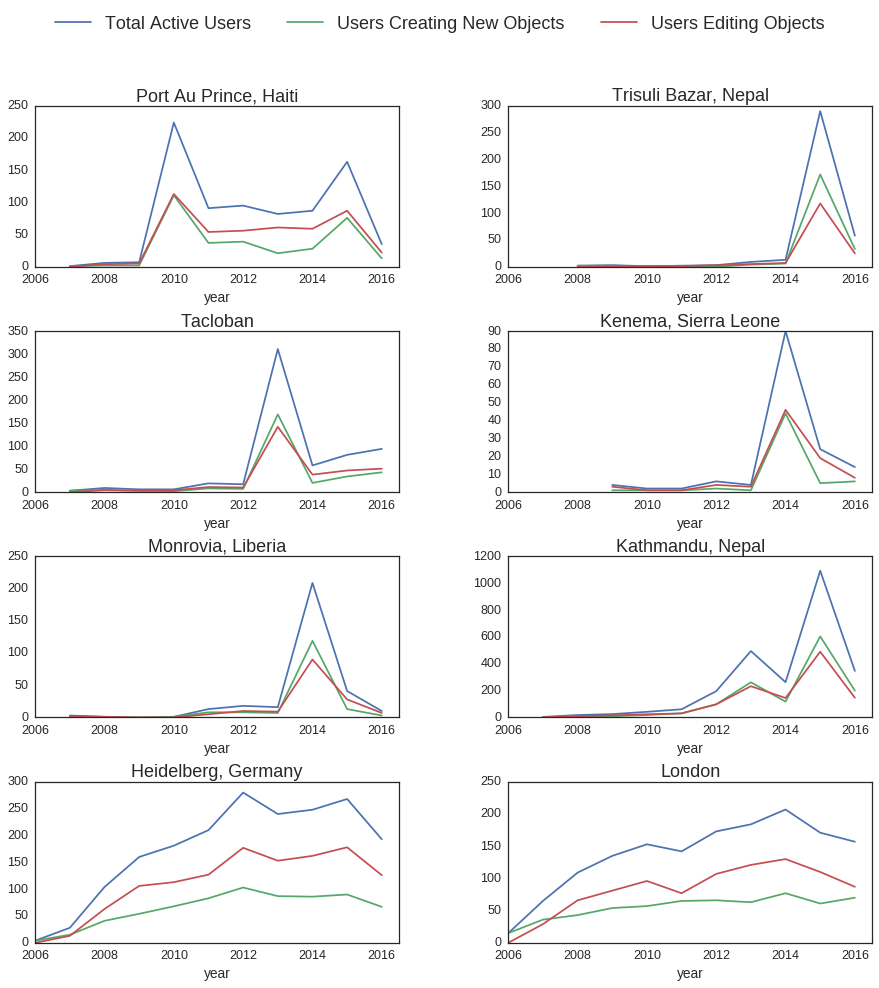

In [333]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
CURSOR = reset_cursor()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
        
    print(tile['name'])
    
    df = tile['df']
    
    df['total_active_users']  = df.users_new_obj + df.users_edited_obj
        
    df.plot(ax=ax, x='year', y='total_active_users', legend=False)
    df.plot(ax=ax, x='year', y='users_new_obj', legend=False)
    df.plot(ax=ax, x='year', y='users_edited_obj', legend=False)

    ax.set_xlim(2006,2016.5)
#     ax.set_ylim(0,1)
    ax.set_title(tile['name'],fontsize=18)
    
plt.figlegend( ax.get_lines(),
              ["Total Active Users",
               "Users Creating New Objects",
               "Users Editing Objects"], 
                loc = ('upper center'), ncol=3, fontsize=18)

## How comparable are the tiles themselves?

In [138]:
for tile in study_tiles:
    df = tile['df']
    print(tile['name'])
    print("Edited Objects: ", df['edited_objects'].sum())
    print("New Objects: ", df['new_objects'].sum())
    print("------------------------\n")

Port Au Prince, Haiti
Edited Objects:  24378
New Objects:  20156
------------------------

Trisuli Bazar, Nepal
Edited Objects:  2674
New Objects:  8635
------------------------

Tacloban
Edited Objects:  24951
New Objects:  10422
------------------------

Kenema, Sierra Leone
Edited Objects:  1431
New Objects:  18149
------------------------

Monrovia, Liberia
Edited Objects:  1587
New Objects:  21348
------------------------

Heidelberg, Germany
Edited Objects:  54611
New Objects:  39413
------------------------

Kathmandu, Nepal
Edited Objects:  34385
New Objects:  88602
------------------------



In [54]:
CURSOR = reset_cursor()
CURSOR.execute("SELECT year, sum(new_objects), sum(edited_objects), sum(users_new_obj), sum(users_edited_obj) FROM \
    tiles_per_year group by year order by year")

In [83]:
res = CURSOR.fetchall()

In [84]:
res

[[2005, 17121, 0, 743, 0],
 [2006, 5637218, 0, 61754, 0],
 [2007, 179710988, 2005407, 514216, 164452],
 [2008, 60120547, 12241179, 912023, 1030631],
 [2009, 24193233, 20049994, 1331694, 2501955],
 [2010, 49170632, 26955958, 2027102, 5978056],
 [2011, 45017727, 37639138, 1582851, 6273485],
 [2012, 54845153, 43305208, 2068155, 12801068],
 [2013, 58297480, 58283164, 2205361, 20586274],
 [2014, 80382230, 66167067, 1811308, 22842122],
 [2015, 67910141, 61167949, 2048521, 20106837],
 [2016, 50421244, 28948011, 1342691, 2552116]]

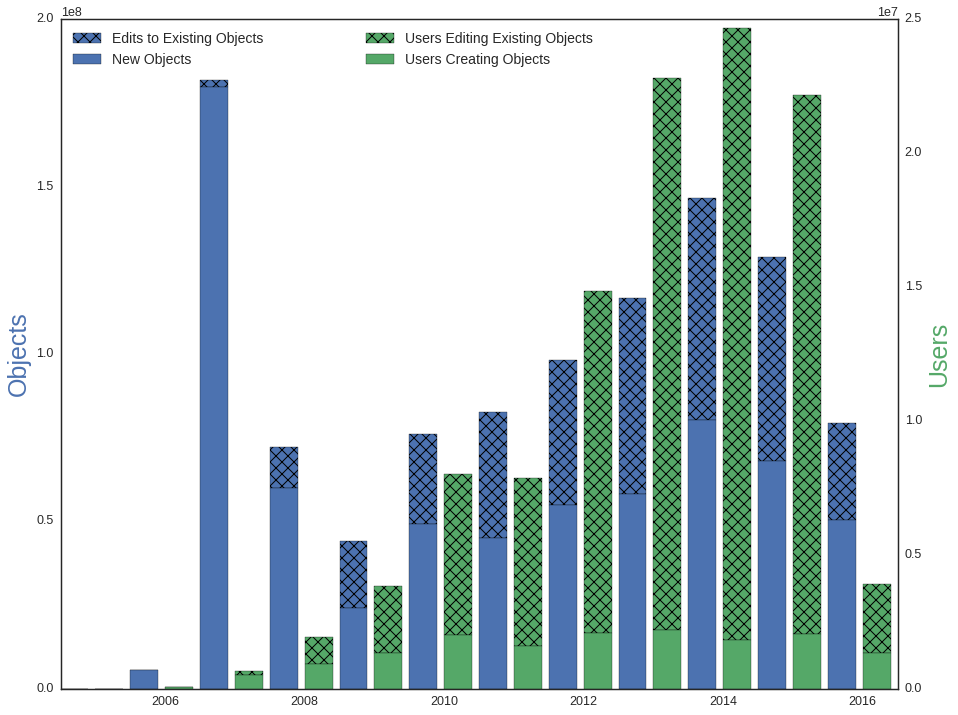

In [135]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
CURSOR = reset_cursor()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')
        
X             = [x[0] for x in res]
new_obj       = [x[1] for x in res]
edited_obj    = [x[2] for x in res]
new_users     = [x[3] for x in res]
editing_users = [x[4] for x in res]

ax2 = ax.twinx()


X1 = [x-0.5 for x in X]

ax.bar(X1, edited_obj, bottom=new_obj, width=0.4, color=colors[0], 
       hatch="XX", label="Edits to Existing Objects")
ax.bar(X1, new_obj, width=0.4, color=colors[0], label="New Objects")

ax.set_ylabel("Objects", color=colors[0], fontsize=25)

X2 = X

ax2.bar(X2, editing_users, bottom=new_users, width=0.4,  color=colors[1], 
       hatch="XX", label="Users Editing Existing Objects")
ax2.bar(X2, new_users, width=0.4, color=colors[1], label="Users Creating Objects")

ax2.set_ylabel("Users", color=colors[1], fontsize=25)

ax.set_xlim(2004.5,2016.5)

ax.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper center', fontsize=14)